In [51]:

def preprocess(data, target_label='checked'):
    
    # Define your features and target
    X = data.drop(target_label, axis=1)
    y = data[target_label]

    return X, y

from sklearn.metrics import recall_score, roc_auc_score

def custom_scoring(y_true, y_pred, fp_threshold=0.0075):
  """
  Custom scoring function that combines recall with false positive control.

  Args:
      y_true: Ground truth labels.
      y_pred: Predicted labels.
      fp_threshold: Maximum tolerable false positive rate.

  Returns:
      A score combining recall and false positive control.
  """
  recall = recall_score(y_true, y_pred)
  false_positives = (y_pred == 1) & (y_true == 0)
  false_positive_rate = false_positives.sum() / len(y_true)
  penalty = 0  # Adjust penalty weight for false positives
  if false_positive_rate > fp_threshold:
    penalty = (false_positive_rate - fp_threshold) ** 2  # Increase penalty quadratically for exceeding threshold
  return recall - penalty


from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.14, 0.145, 0.15],
    'n_estimators': [350, 400],
    'max_depth': [5],
    'min_samples_split': [900],
    'min_samples_leaf': [120, 125],
}


# Create the GradientBoostingClassifier model
model = GradientBoostingClassifier()

# Define the GridSearchCV object
grid_search = RandomizedSearchCV(model, param_grid, scoring=custom_scoring, cv=5, n_jobs=4)



model = GradientBoostingClassifier()

ds_train = pd.read_csv('./../data/train.csv')
ds_test = pd.read_csv('./../data/test.csv')
instance_weights = pd.read_csv('./../data/instance_weights.csv')['instance_weights']
print(instance_weights.shape)

X_train, y_train = preprocess(ds_train)
X_test, y_test = preprocess(ds_test)
    
# Fit the grid search to the data
grid_search.fit(X_train, y_train, sample_weight=instance_weights.to_numpy())

    
# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

y_pred_rew = grid_search.predict(X_test)

results = classification_report(y_pred_rew, y_test)
(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred_rew).ravel()
print(f"tn: {tn} fp: {fp} fn: {fn} tp: {tp} ")
print(results)


(10116,)


In [49]:
(tn, fp, fn, tp) = confusion_matrix(y_test, y_pred_rew).ravel()


print(f"tn: {tn} fp: {fp} fn: {fn} tp: {tp} ")


tn: 2235 fp: 25 fn: 107 tp: 162 


In [9]:
# Example usage (replace with your actual model, data, and feature name)
model = GradientBoostingClassifier(n_estimators=300, min_samples_split=800, min_samples_leaf=130, max_depth=5, learning_rate=0.145)

ds_train = pd.read_csv('./../data/train.csv')
ds_test = pd.read_csv('./../data/test.csv')

instance_weights = pd.read_csv('./../data/instance_weights.csv')['instance_weights']

X_train, y_train = preprocess(ds_train)
X_test, y_test = preprocess(ds_test)

# Fit the grid search to the data
model.fit(X_train, y_train, sample_weight=instance_weights.to_numpy())

# Make predictions on the test set
y_pred = model.predict(X_test)

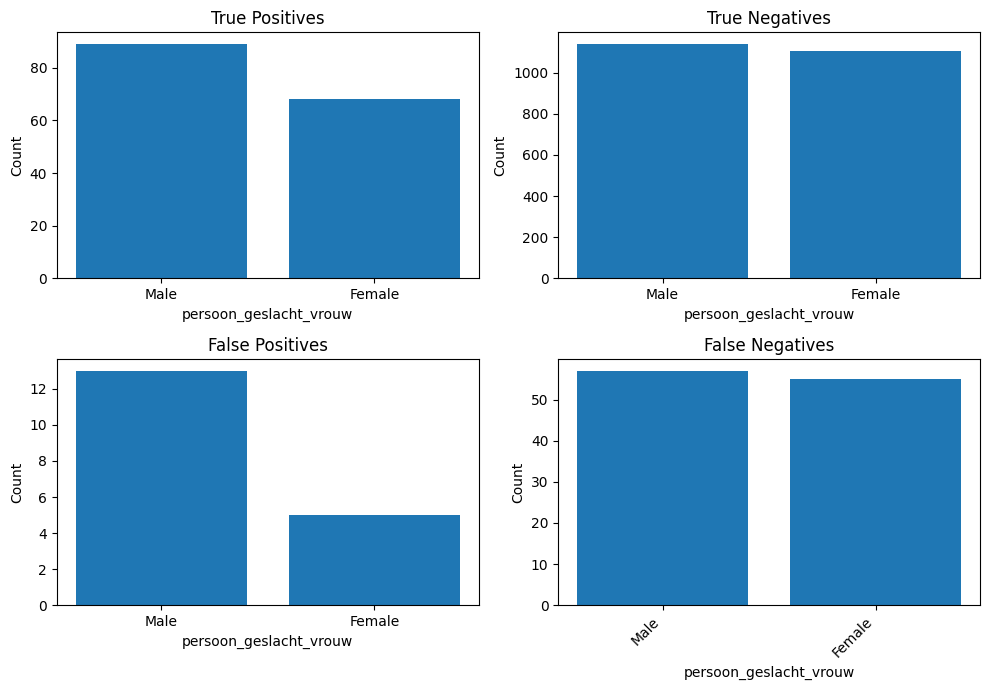

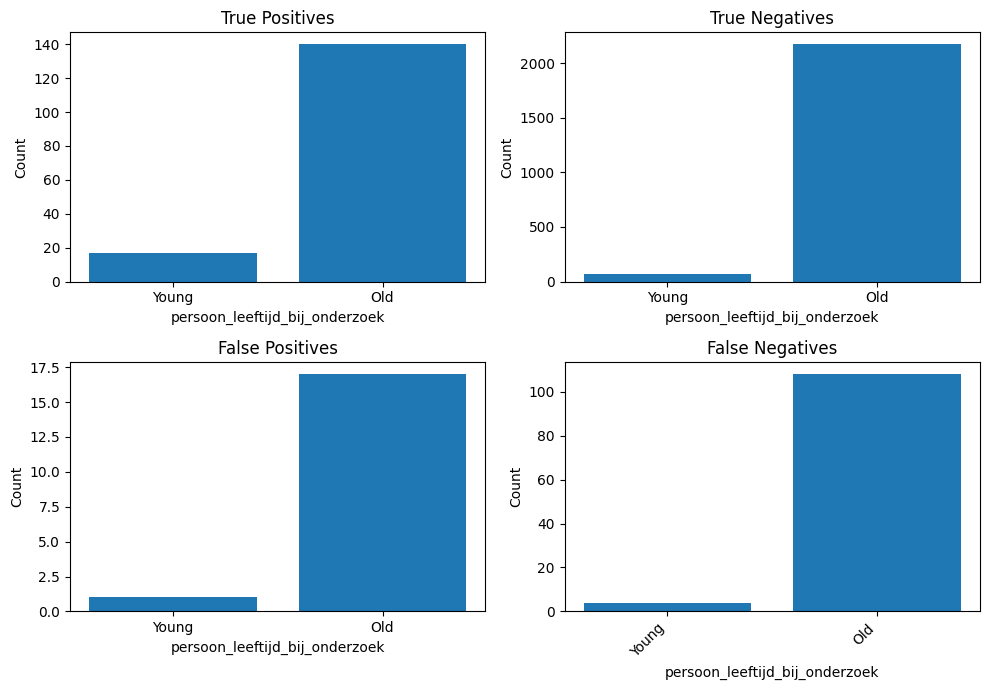

In [43]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def plot_classification_by_feature(X_test, y_test, y_pred, feature_name, feature_map=None):
    """
    Plots true negatives, true positives, false negatives, and false positives grouped by a feature.

    Args:
        model: Trained GradientBoostingClassifier model.
        X_test: Pandas dataframe containing the test features.
        y_test: Pandas Series containing the true labels for the test set.
        feature_name: Name of the feature to group classifications by.
    """

    # Store counts for each classification type and feature value
    class_counts = {'TP': {0: 0, 1: 0}, 'TN': {0: 0, 1: 0}, 'FP': {0: 0, 1: 0}, 'FN': {0: 0, 1: 0}}
    for i, (y_true, y_pred, feature_value) in enumerate(zip(y_test, y_pred, X_test[feature_name])):
        if y_true == 1 and y_pred == 1:
            class_counts['TP'][feature_value] += 1
        elif y_true == 1 and y_pred == 0:
            class_counts['FN'][feature_value] += 1
        elif y_true == 0 and y_pred == 1:
            class_counts['FP'][feature_value] += 1
        else:
            class_counts['TN'][feature_value] += 1

    # Extract data for plotting
    unique_features = sorted(set(X_test[feature_name]))

    # Create the figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 7))


    features = []
    if feature_map != None:
        
        for feature_value in unique_features:
            features.append(feature_map[feature_value])
    else:
        features = unique_features
    
    
    # Plot true positives
    axes[0, 0].bar(features, [class_counts['TP'][v] for v in unique_features], label='True Positives')
    axes[0, 0].set_xlabel(feature_name)
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('True Positives')
    axes[0, 0].set_xticks(unique_features)

    # Plot true negatives
    axes[0, 1].bar(features, [class_counts['TN'][v] for v in unique_features], label='True Negatives')
    axes[0, 1].set_xlabel(feature_name)
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('True Negatives')
    axes[0, 1].set_xticks(unique_features)

    # Plot false positives
    axes[1, 0].bar(features, [class_counts['FP'][v] for v in unique_features], label='False Positives')
    axes[1, 0].set_xlabel(feature_name)
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('False Positives')
    axes[1, 0].set_xticks(unique_features)

    # Plot false negatives
    axes[1, 1].bar(features, [class_counts['FN'][v] for v in unique_features], label='False Negatives')
    axes[1, 1].set_xlabel(feature_name)
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('False Negatives')
    axes[1, 1].set_xticks(unique_features)

    # Common x labels for all subplots
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


  
feature_name1= 'persoon_geslacht_vrouw'
feature_name2 = 'persoon_leeftijd_bij_onderzoek'
# Define a function to conditionally change age values
def change_age_category(age):
  if age < 30:
    return 0
  else:
    return 1

X_test_age = X_test.copy()
# Apply the function to the 'age' column using vectorized operations
X_test_age[feature_name2] = X_test[feature_name2].apply(change_age_category)

plot_classification_by_feature(X_test, y_test, y_pred, feature_name1, feature_map={0: 'Male', 1: 'Female'})
plot_classification_by_feature(X_test_age, y_test, y_pred, feature_name2, feature_map={0: 'Young', 1: 'Old'})